## Select closest points using CKDTree

To select closest grid points, we will use here one approach using [cKDTree](http://docs.scipy.org/doc/scipy-0.12.0/reference/generated/scipy.spatial.cKDTree.html) class from scipy.spatial package.

Two methods of interpolation are considered here: nearest neighbour and weighting with the inverse of distance squared:

$T_t = frac{\\sum_{i=1}^{m}T_{s,i}w_i}{\\sum_{i=1}^{m}w_i}$, $w_i = 1/d_i^2$).


In [1]:
#for Netcdf manipulation
import xarray as xr

#for array manipulation
import numpy as np
import pandas as pd

#for plotting

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pylab as plt

#for interpolation
from scipy.spatial import cKDTree

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import timedelta

from scipy import stats

D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


First we load Netcdf data.

In [2]:
unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_FWI_Netcdf/ERA5_FWI_QC_SNOW_New_2018_from_4_to_8.nc'
TAS = xr.open_dataset(unique_dataDIR)

In [3]:
lon2d, lat2d = np.meshgrid(TAS.lon, TAS.lat)

In [4]:
class KDTreeIndex():
    
    """ A KD-tree implementation for fast point lookup on a 2D grid
    
    Keyword arguments: 
    dataset -- a xarray DataArray containing lat/lon coordinates
               (named 'lat' and 'lon' respectively)
               
    """
    
    def transform_coordinates(self, coords):
        """ Transform coordinates from geodetic to cartesian
        
        Keyword arguments:
        coords - a set of lan/lon coordinates (e.g. a tuple or 
                 an array of tuples)
        """
        # WGS 84 reference coordinate system parameters
        A = 6378.137 # major axis [km]   
        E2 = 6.69437999014e-3 # eccentricity squared    
        
        coords = np.asarray(coords).astype(np.float)
        
        # is coords a tuple? Convert it to an one-element array of tuples
        if coords.ndim == 1:
            coords = np.array([coords])
        
        # convert to radiants
        lat_rad = np.radians(coords[:,0])
        lon_rad = np.radians(coords[:,1]) 
        
        # convert to cartesian coordinates
        r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
        x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
        y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
        z = r_n * (1 - E2) * np.sin(lat_rad)
        
        return np.column_stack((x, y, z))
    
    def __init__(self, dataset):
        # store original dataset shape
        self.shape = dataset.shape
        lon2d, lat2d = np.meshgrid(dataset.lon, dataset.lat)
        # reshape and stack coordinates
        coords = np.column_stack((lat2d.ravel(),
                                  lon2d.ravel()))
        
        # construct KD-tree
        self.tree = cKDTree(self.transform_coordinates(coords))
        
    def query(self, point, k):
        """ Query the kd-tree for nearest neighbour.

        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        """
        d, inds  = self.tree.query(self.transform_coordinates(point),k=k)
        w = 1.0 / d**2
        # regrid to 2D grid
        indslatlon = np.unravel_index(inds, self.shape)
        # return DataArray indexers
        return d, inds, w, indslatlon
       # return xr.DataArray(index[0], dims='pixel'), \
       #        xr.DataArray(index[1], dims='pixel')

In [5]:
ground_pixel_tree = KDTreeIndex(TAS.sel(time='2018-08-01').FWI)

In [6]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_2018.csv", sep=",")
stations.head()

,NoStation,latD,lonD
0,111,45.6222,-76.0192
1,129,45.2942,-73.3489
2,132,47.1564,-78.9339
3,142,46.0853,-76.5511
4,145,46.6947,-78.0611


## Loop over all year from 2010 to 2018 and stations using stations' index

In [7]:
for year in range(2010,2019):
    unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_FWI_Netcdf/ERA5_FWI_QC_SNOW_New_'+str(year)+'_from_4_to_8.nc'
    TAS = xr.open_dataset(unique_dataDIR)   
    stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_"+str(year)+".csv", sep=",")
    FWI_kpts_model = pd.DataFrame()
    for i, row in stations.iterrows(): 
        site = row['latD'], row['lonD']
        d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
        FWI_kpts = []    
        for day in TAS.time: 
            FWI_kpts.append((np.nansum(w * TAS.sel(time=day).FWI.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0])
        FWI_kpts_model[str(int(row[0]))] = FWI_kpts
        
    FWI_kpts_model['Date'] = TAS.time
    FWI_kpts_model = FWI_kpts_model.set_index('Date')
    FWI_kpts_model.to_csv("K:/PROJETS/PROJET_FIRE_INDEX/Closest_points/FWI_kpts_model_"+str(year)+".csv", header = True, sep = ',')  

## Select time range using ERA5 Onset 

In [8]:
import gc
gc.collect()
correlation =[] 
df_pvalue = [] 
df_lat = [] 
df_lon = []
df_year = []
df_NoStation = []
FWI_kpts_model=pd.DataFrame()
df_Size = []

for year in range(2010,2019):
    unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_FWI_Netcdf/ERA5_FWI_QC_SNOW_New_'+str(year)+'_from_4_to_8.nc'
    TAS = xr.open_dataset(unique_dataDIR)
    stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_"+str(year)+".csv", sep=",")     
    FWI_kpts_model=pd.DataFrame()
    for i, row in stations.iterrows(): 
        site = row['latD'], row['lonD']
        d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
        FWI_kpts = []    
        for day in TAS.time: 
            FWI_kpts.append((np.nansum(w * TAS.sel(time=day).FWI.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0])
        FWI_kpts_model[str(int(row[0]))] = FWI_kpts
        
    FWI_kpts_model['Date'] = TAS.time
    FWI_kpts_model = FWI_kpts_model.set_index('Date')
    
    unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_Onset_Netcdf/ERA5_SNOW_Onset_'+str(year)+'_from_4_to_8.nc'
    VAR = xr.open_dataset(unique_dataDIR)
    
    stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_"+str(year)+".csv", sep=",")
    
    ERA5_Onset = []   
    for i, row in stations.iterrows(): 
        site = row['latD'], row['lonD']
        d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
        ERA5_Onset.append(int(np.round(np.nansum(w * VAR.Onset.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0]))
    ERA5_Onset = pd.DataFrame(ERA5_Onset)
    ERA5_Onset['Date'] = ERA5_Onset[0].apply(lambda x: datetime.date(year, 4, 1) + timedelta(days=x))    
    
    
    dataframe_stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_FWI_SOPFEU"+str(year)+".csv", encoding='latin-1')
    dataframe_stations = dataframe_stations.set_index('Date')
    i = 0 
    for column in dataframe_stations:
        dataframe_stations[column] = dataframe_stations[column].loc[ERA5_Onset['Date'][i].strftime('%Y-%m-%d'):str(year)+'-08-31']
        i+=1
    i = 0 
    for column in FWI_kpts_model:
        FWI_kpts_model[column] = FWI_kpts_model[column].loc[ERA5_Onset['Date'][i].strftime('%Y-%m-%d'):str(year)+'-08-31']
        i+=1 
    corr_pearson_ERA5 = []
    p_pearson_ERA5 = []   
    for i in range(0,len(dataframe_stations.columns)):         
    # pearson correlation
        r, p = stats.pearsonr(dataframe_stations.iloc[:,i].dropna(axis=0, how='any'),FWI_kpts_model.iloc[:,i].dropna(axis=0, how='any'))     
        corr_pearson_ERA5.append(r)
        p_pearson_ERA5.append(p)
        
    correlation.append(corr_pearson_ERA5)
    df_pvalue.append(p_pearson_ERA5)
    df_lat.append(stations.latD.values)
    df_lon.append(stations.lonD.values+360)
    df_year.append([year] * len(stations.latD.values))
    df_NoStation.append(stations.NoStation.values)
    df_Size.append([10] * len(stations.latD.values))
    

In [9]:
df_correlation =pd.DataFrame()
df_correlation['r_pearson'] = np.concatenate(correlation)
df_correlation['p_pearson'] = np.concatenate(df_pvalue)
df_correlation['latitude'] = np.concatenate(df_lat)
df_correlation['longitude'] = np.concatenate(df_lon)
df_correlation['year'] = np.concatenate(df_year)
df_correlation['NoStation'] = np.concatenate(df_NoStation)
df_correlation['Size'] = np.concatenate(df_Size)

In [10]:
df_correlation.head()

,r_pearson,p_pearson,latitude,longitude,year,NoStation,Size
0,0.872122,8.515760e-48,45.2942,286.6511,2010,129,10
1,-0.081138,3.477125e-01,46.7181,284.0131,2010,151,10
2,0.022671,7.948566e-01,46.9572,286.9944,2010,162,10
3,0.841322,3.732577e-38,46.3275,286.7225,2010,171,10
4,0.080289,3.793432e-01,46.9544,288.3939,2010,173,10


We only keep rows with p_value < 0.1.

In [11]:
df_correlation = df_correlation[(df_correlation['p_pearson'] < 0.1)]

we have a tidy data frame to create a scatter map plot using px.scatter_mapbox. Again, I encourage you to read the documentation to understand the arguments provided to the function.

In [13]:
import plotly
import plotly.express as px

# Create a token in mapbox
token = 'pk.eyJ1IjoiZ3VpbWV0ZW8iLCJhIjoiY2s3ZGpmZGtrMDRzYTNncnZwYTlicXV0dCJ9.BykaOZZP1cmYSc-dmI6ieA'

# Create a scatter map plot. The size of the points represents the price
fig = px.scatter_mapbox(df_correlation,
        lat = 'latitude',
        lon = 'longitude',
        zoom=4.5,
        hover_name='NoStation',       
        size='Size',
        color='r_pearson',
        range_color=(0, 1),
        animation_frame='year',
        color_continuous_scale=[
        # Let values between 10-20% of the min and max of 
        [0.0, "rgb(49,54,149)"],
        [0.1, "rgb(49,54,149)"],

        [0.1, "rgb(69,117,180)"],
        [0.2, "rgb(69,117,180)"],

        [0.2, "rgb(116,173,209)"],
        [0.3, "rgb(116,173,209)"],

        [0.3, "rgb(171,217,233)"],
        [0.4, "rgb(171,217,233)"],

        [0.4, "rgb(224,243,248)"],
        [0.5, "rgb(224,243,248)"],

        [0.5, "rgb(254,224,144)"],
        [0.6, "rgb(254,224,144)"],

        [0.6, "rgb(253,174,97)"],
        [0.7, "rgb(253,174,97)"],

        [0.7, "rgb(244,109,67)"],
        [0.8, "rgb(244,109,67)"],

        [0.8, "rgb(215,48,39)"],
        [0.9, "rgb(215,48,39)"],
            
        [0.9, "rgb(165,0,38)"],
        [1.0, "rgb(165,0,38)"],    
            
    ],
                        
        width = 1000,
        height = 1000
        )
# Configure the style of the map
fig.update_layout(
        mapbox_style="light", 
        mapbox_accesstoken=token
    )
fig.show()
plotly.offline.plot(fig, filename = 'Correlation_ERA5_SOPFEU.html', auto_open=False)

'Correlation_ERA5_SOPFEU.html'

## Compute RMSE using sklearn

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

df_rmse = pd.DataFrame()
rmse = []
for i in range(0,len(dataframe_stations.columns)): 
    # RMSE 
    rms = sqrt(mean_squared_error(dataframe_stations.iloc[:,i].dropna(axis=0, how='any'), FWI_kpts_model.iloc[:,i].dropna(axis=0, how='any')))     
    rmse.append(rms)
    
df_rmse['rmse'] = rmse
df_rmse['Lat'] = stations.latD.values
df_rmse['Lon'] = stations.lonD.values  

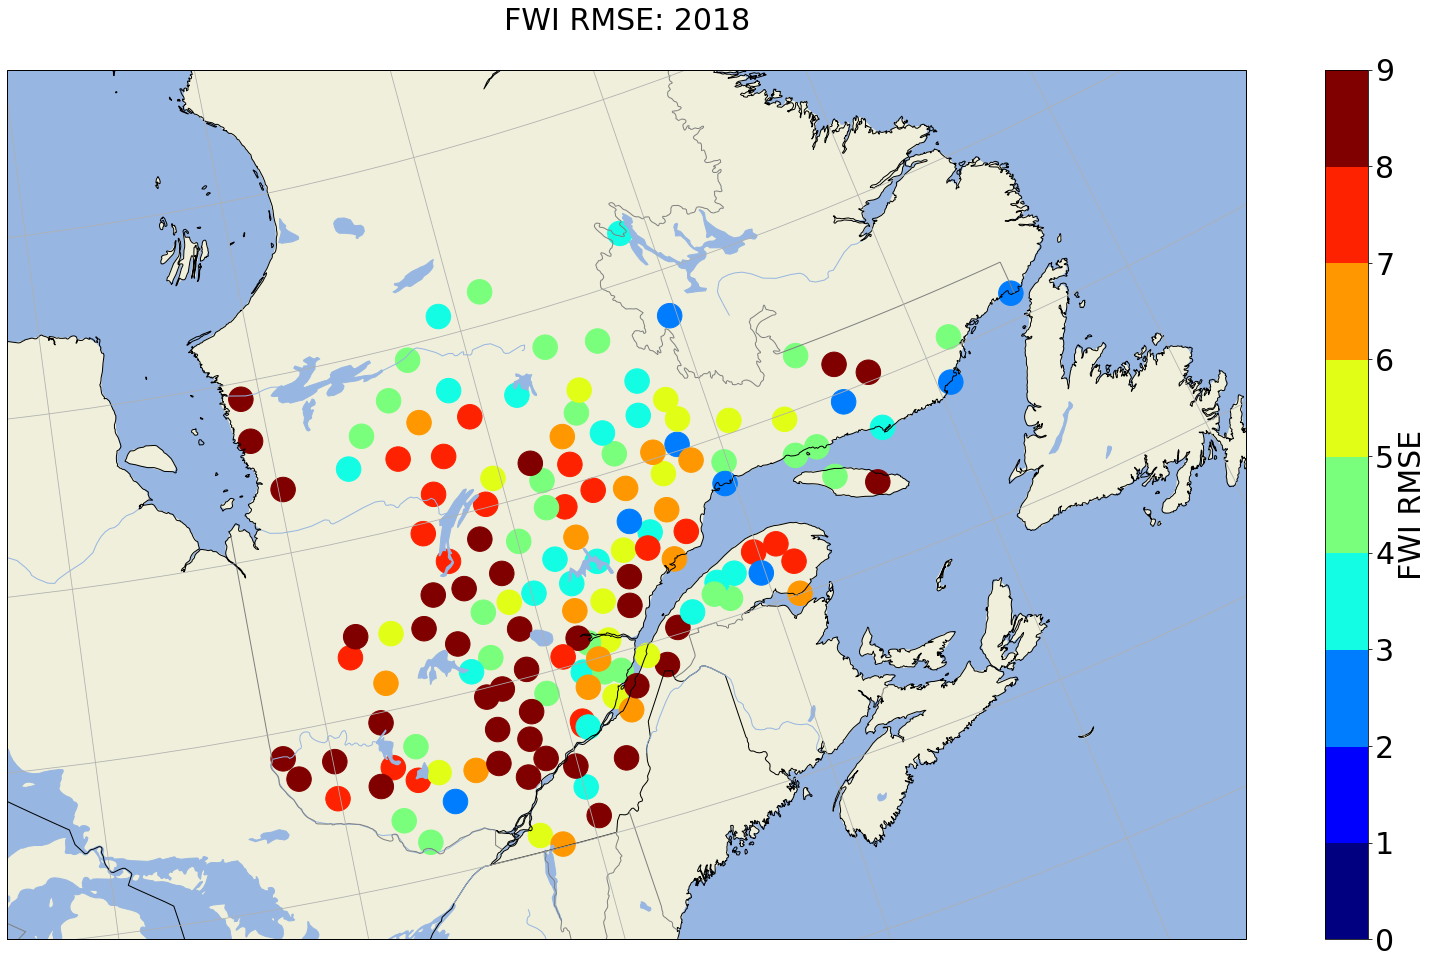

In [19]:
fig=plt.figure(figsize=(28,16), frameon=True) 
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-85,-55,45,55])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
  
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')   
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
   
ax.add_feature(states_provinces, edgecolor='gray')

cmap = plt.cm.jet  # define the colormap
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)

# Plots the data onto map
plt.scatter(df_rmse['Lon'], 
            df_rmse['Lat'],
            alpha=1.,
            s=600, label="RMSE",
            c=df_rmse['rmse'],
            vmin=0,
            vmax=10,
            cmap=plt.get_cmap("jet"),
            norm=norm,
            transform=ccrs.PlateCarree())
       
ax.gridlines()
# Colorbar
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(["%d"%(v) for v in tick_values], fontsize=14)
cbar.set_label('FWI RMSE', fontsize=30)
string_title=u'FWI RMSE: 2018\n'
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=30)

plt.title(string_title, size='xx-large', fontsize=30)
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Quebec_RMSE_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Text(0, 0.5, 'FWI ERA5 closest point')

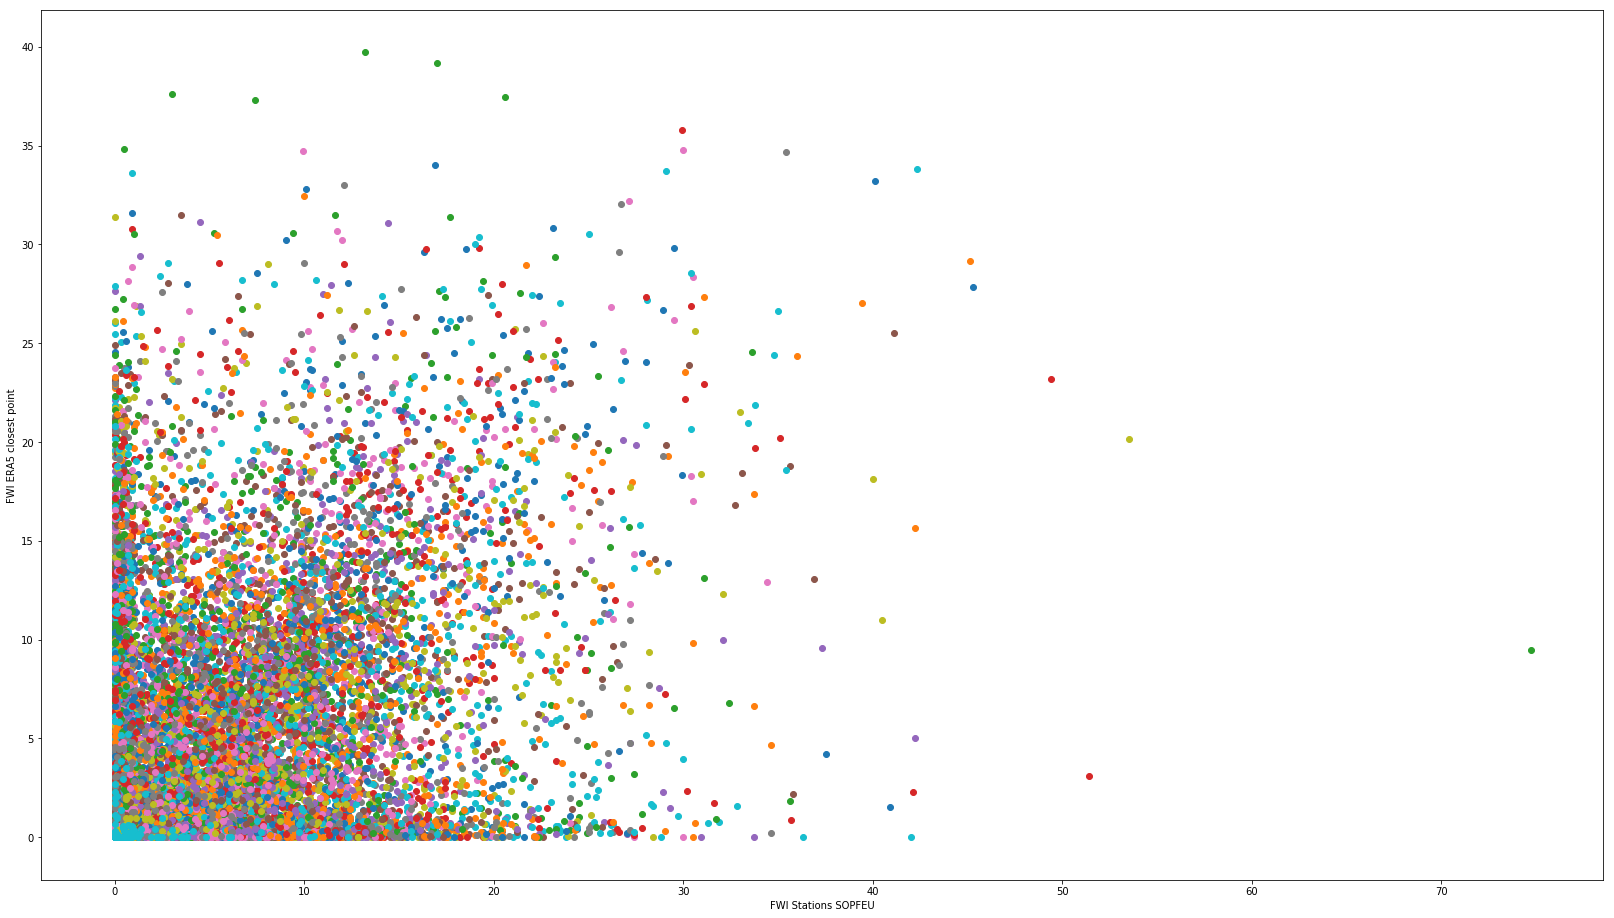

In [20]:
#dataframe_stations.corrwith(other=FWI_kpts_model)
fig=plt.figure(figsize=(28,16), frameon=True) 
for col in dataframe_stations.columns:
    plt.scatter(dataframe_stations[col], FWI_kpts_model[col], label=col)
#plt.legend(loc='best', fontsize=16)
plt.xlabel('FWI Stations SOPFEU')
plt.ylabel('FWI ERA5 closest point')